# ML Проект. Heart Disease Dataset

## Описание данных

(Из каггла)

This data set dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V. It contains 76 attributes, including the predicted attribute, but all published experiments refer to using a subset of 14 of them. The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease.

**Columns:**

- age
- sex
- chest pain type (4 values)
- resting blood pressure
- serum cholestoral in mg/dl
- fasting blood sugar > 120 mg/dl
- resting electrocardiographic results (values 0,1,2)
- maximum heart rate achieved
- exercise induced angina
- oldpeak = ST depression induced by exercise relative to rest
- the slope of the peak exercise ST segment
- number of major vessels (0-3) colored by flourosopy
- thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
- target: 0 - no disease; 1 - disease


The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## EDA

Общая информация о датасете:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Есть ли нулевые значения:

In [4]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Есть ли дубликаты:

In [5]:
df.duplicated().sum()

723

Примерно 70% датасета - это дублирующиеся значения. Кажется, это плохо для построения моделей, поэтому удаляем их:

In [6]:
df_clear = df.drop_duplicates()
df_clear.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [7]:
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 878
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


В результате у нас осталось всего 302 записи

In [8]:
df_clear.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Отсюда видим, что:
- средний возраст пациентов в выборке - 54 (медиана - 55), в целом в выборке есть данные о людях от 29 до 77 лет.
- 68% выборки - мужчины, 32% - женщины
- для показателя cp (chest pain) среднее значение - 0,96 (медиана - 1)
- среднее значение показателя trestbps - 131 (медиана 130), при этом минимальное значение - 94, а максимальное достигает 200
- холестерол - среднее значение 246,5 (медиана - 240,5), при этом значения варьируются от 126 до 564
- для показателя fbs среднее значение - 0,149 (медиана 0) 
- по показателю restecg среднее значение - 0,52
- по показателю thalach среднее значение 149,5 (медиана 152,5), значения варьируются в диапазоне от 71 до 202
- по показателю exang среднее значение - 0,32
- по показателю oldpeak среднее значение - 0,32, при этом значения варьируются от 0 до 6,2
- для slope среднее значение - 1,39 (медиана 0,8)
- по показателю ca среднее значение - 0,71 (медиана - 0), значения варьируются от 0 до 4
- по показателю thal среднее значение - 2,31 (медиана - 2). Значения варьируются от 0 до 3. 
- 54,3% пациентов имеют заболевание

In [9]:
df_clear.groupby('sex').mean()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
sex,,,,,,,,,,,,,
0,55.677083,1.041667,133.083333,261.302083,0.125000,0.572917,151.12500,0.229167,0.876042,1.427083,0.552083,2.125000,0.750000
1,53.834951,0.927184,130.912621,239.601942,0.160194,0.504854,148.84466,0.373786,1.120874,1.383495,0.796117,2.402913,0.446602


Если смотреть на данные в разбивке по полу, можно увидеть, что в выборке у женщин заболевания сердца встречаются чаще: они есть в среднем у 75% женщин и лишь 44,6% мужчин. Различаются показатели и по другим параметрам, например, холестерол у женщин в среднем равен 261,3, а у мужчин - 239,6. При этом показатели exang, oldpeak, ca, thal выше у пациентов мужского пола. Тем не менее, без проведения стат. тестов нельзя говорить о статистически значимой разницы между показателями.

In [10]:
df_clear.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.601449,0.826087,0.478261,134.398551,251.086957,0.159420,0.449275,139.101449,0.550725,1.585507,1.166667,1.166667,2.543478
1,52.585366,0.560976,1.371951,129.250000,242.640244,0.140244,0.591463,158.378049,0.140244,0.586585,1.591463,0.341463,2.121951


При разделении выборки по признаку наличия или отсутствия сердеченого заболевания видно, что показатель cp (уровень боли в груди) в группе с заболеванием практически в 3 раза выше, чем в группе тех, у кого заболевание отсутствует. Также у имеющих заболевание выше показатель холестерола, restecg, thalach и ca. При этом такие показатели как exang и oldpeak выше у людей, не имеющих сердечных заболеваний.

In [11]:
df_clear.groupby(['sex', 'target']).mean()

age        cp    trestbps        chol       fbs   restecg  \
sex target                                                                    
0   0       59.041667  0.166667  146.125000  274.958333  0.250000  0.541667   
    1       54.555556  1.333333  128.736111  256.750000  0.083333  0.583333   
1   0       56.087719  0.543860  131.929825  246.061404  0.140351  0.429825   
    1       51.043478  1.402174  129.652174  231.597826  0.184783  0.597826   

               thalach     exang   oldpeak     slope        ca      thal  
sex target                                                                
0   0       142.416667  0.583333  1.841667  0.958333  1.291667  2.500000  
    1       154.027778  0.111111  0.554167  1.583333  0.305556  2.000000  
1   0       138.403509  0.543860  1.531579  1.210526  1.140351  2.552632  
    1       161.782609  0.163043  0.611957  1.597826  0.369565  2.217391

При разделении выборки на группы по полу и наличию заболевания прослеживаются уже описанные выше паттерны. У женщин и мужчин с сердечными заболеваниями в несколько раз увеличен показатель cp (боль в груди), понижены уровень холестерола, показатели exang, oldpeak и ca, повышен показатель thalach. На этом этапе можем предположить, что эти переменные вносят наиболее сильно связаны с наличием заболевания.

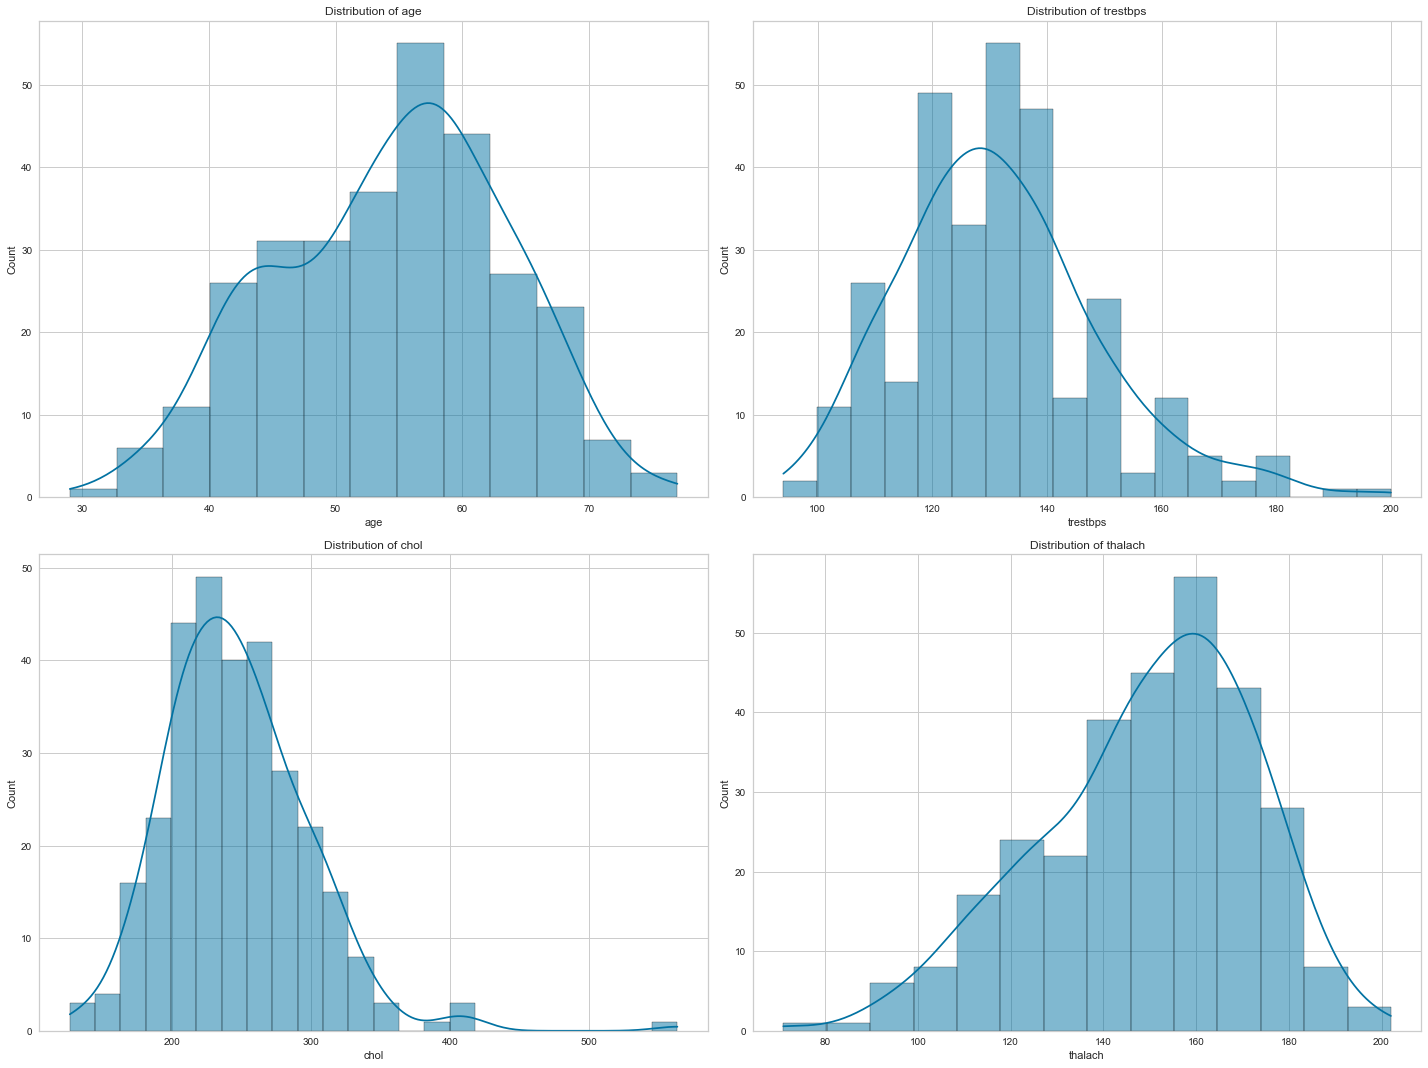

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))


continuous_vars = ["age", "trestbps", "chol", "thalach"]

for i, var in enumerate(continuous_vars):
    row = i // 2
    col = i % 2

    sns.histplot(data=df_clear, x=var, kde=True, ax=axes[row, col])

    axes[row, col].set_xlabel(var)
    axes[row, col].set_title(f"Distribution of {var}")


plt.tight_layout()
plt.show()

Все распределения в целом выглядят нормально

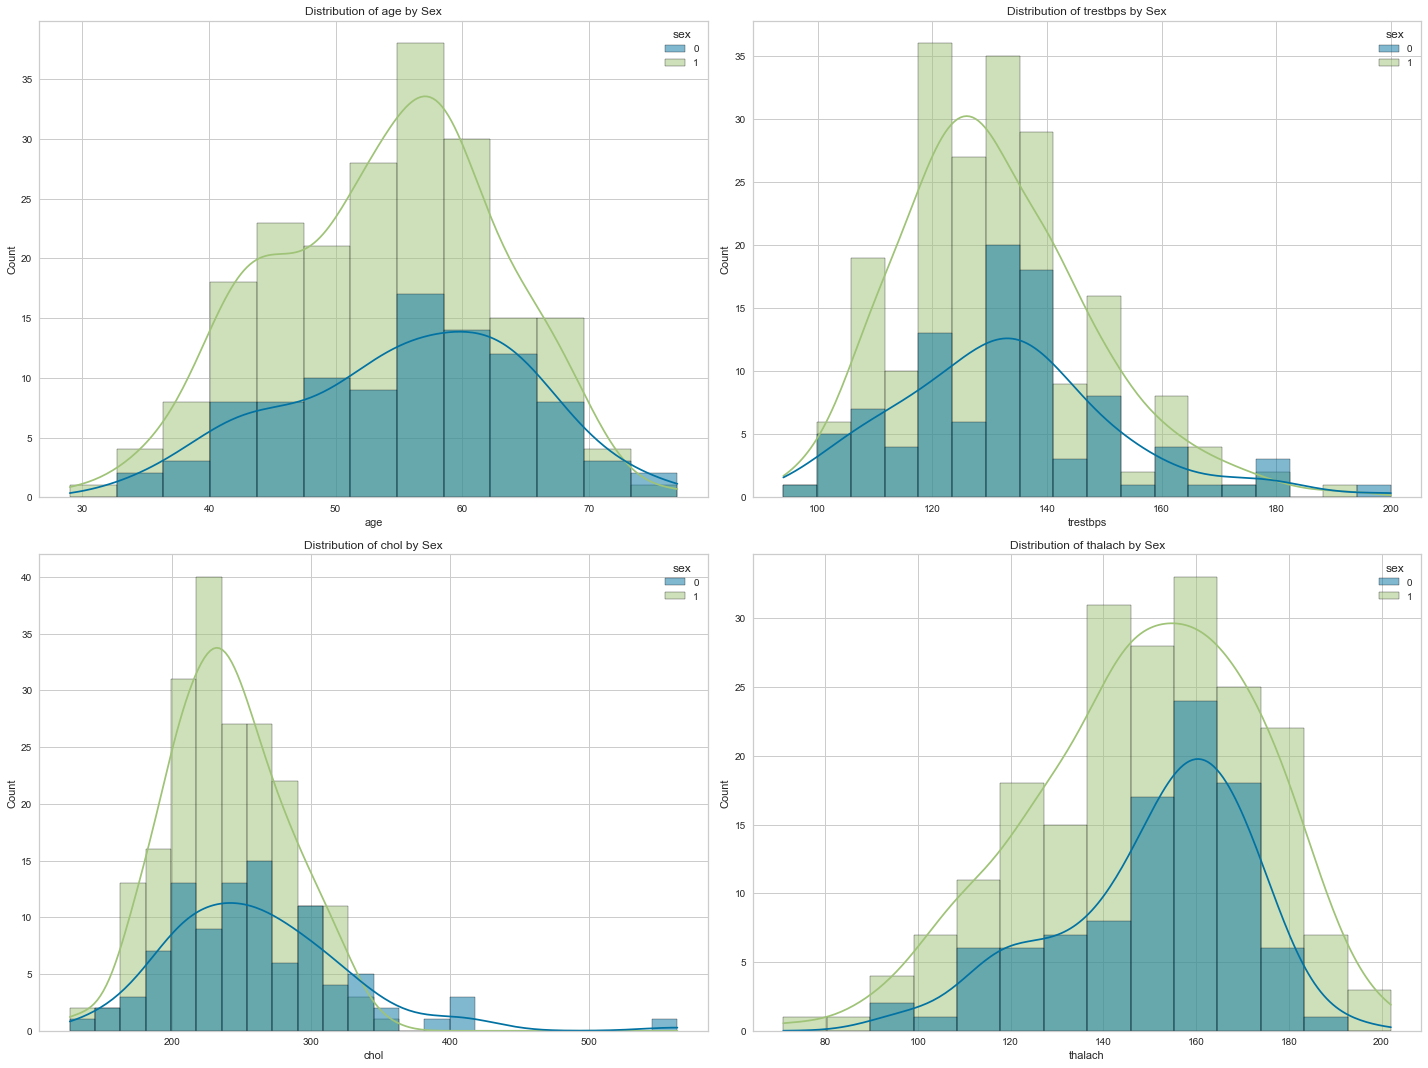

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))


continuous_vars = ["age", "trestbps", "chol", "thalach"]

for i, var in enumerate(continuous_vars):
    row = i // 2
    col = i % 2

    sns.histplot(data=df_clear, x=var, hue="sex", kde=True, ax=axes[row, col])

    axes[row, col].set_xlabel(var)
    axes[row, col].set_title(f"Distribution of {var} by Sex")


plt.tight_layout()
plt.show()

В целом, судя по графикам выше, распределение показателей примерно одинаково у мужчин и женщин

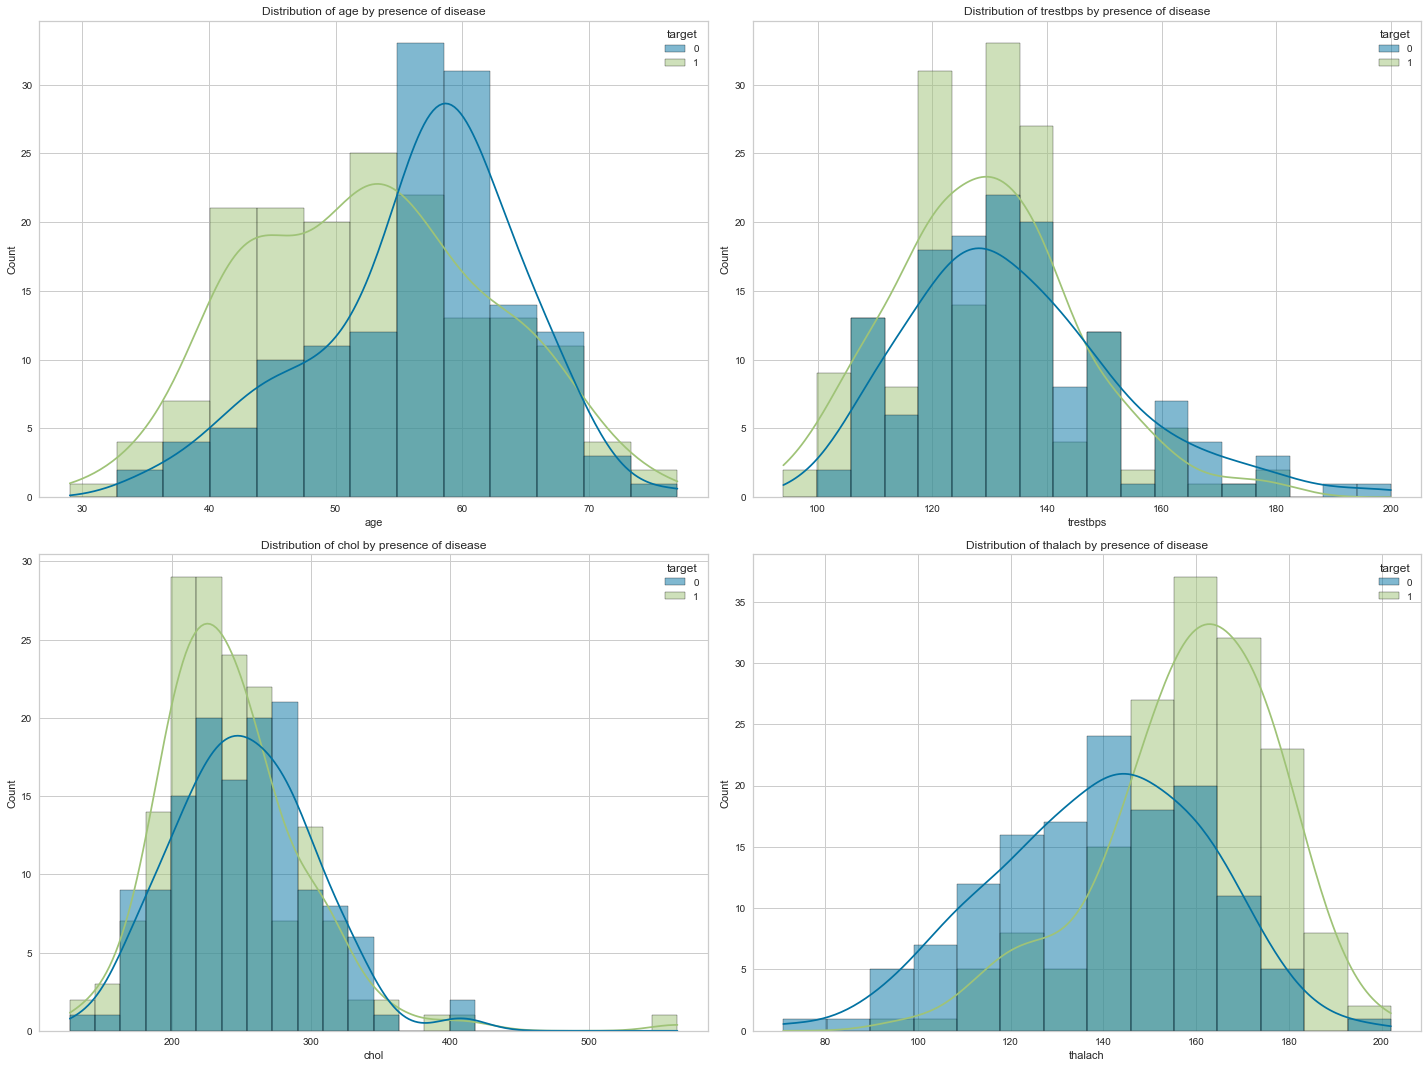

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))


continuous_vars = ["age", "trestbps", "chol", "thalach"]

for i, var in enumerate(continuous_vars):
    row = i // 2
    col = i % 2

    sns.histplot(data=df_clear, x=var, hue="target", kde=True, ax=axes[row, col])

    axes[row, col].set_xlabel(var)
    axes[row, col].set_title(f"Distribution of {var} by presence of disease")


plt.tight_layout()
plt.show()

Из графиков видно, что в выборке люди, имеющие сердечные заболевания, в среднем моложе - большая часть значений в диапазоне 40-60.

Также видно, что показатель thalach повышен у людей с сердечными заболеваниями. 

Показатели trestbps и chol распределены примерно одинаково в обеих группах

<AxesSubplot:>

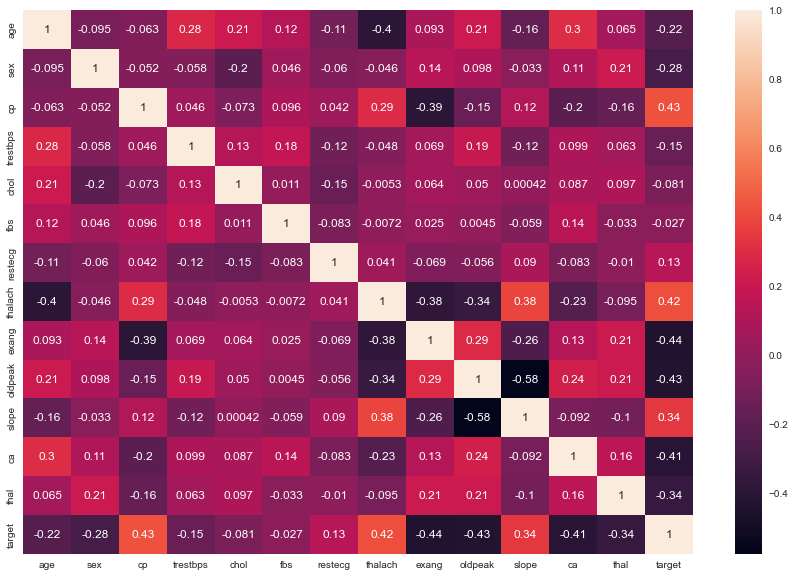

In [16]:
plt.figure(figsize=(15 , 10))
sns.heatmap(df_clear.corr() , annot=True)

Видим, что переменные age, sex, cp, thalach, exang, oldpeak, slope, ca, thal имеют корреляцию с переменной target (как положительную, так и отрицательную). Это кажется логичным, т.к. в датасете собраны переменные, которые связаны с наличием или отсутствием у пациента заболевания. 

Помимо этого наиболее сильная корреляция наблюдается между переменными:
- age и trestbps (0,28)
- age и thalach (-0,4)
- cp и exang (-0,39)
- thalach и exang (-0,38)
- thalach и oldpeak (-0,34)
- oldpeak и slope (-0,58)

**Выводы**

После первичного анализа мы увидели, что:
- сердечные заболевания чаще встречаются у женщин
- У женщин и мужчин с сердечными заболеваниями в несколько раз увеличен показатель cp (боль в груди), понижены уровень холестерола, показатели exang, oldpeak и ca, повышен показатель thalach. 

После изучения датасета можно поставить следующие **задачи**:
- Понять, какие переменные вносят наиболее весомый вклад в предсказание наличия/отсутствия заболевания
- Обучить классификатор для предсказания наличия/отсутствия заболевания по имеющимся данным
- Разделить выборку на кластеры и более детально посмотреть на отличительные особенности пациентов с сердечными заболеваниями и без

## Регрессия

#### Линейная регрессия

На прошлом шаге мы увидели наиболее сильную отрицательную корреляцию между переменными age и thalach. С помощью линейной регрессии посмотрим, насколько значима связь между перемеными. 

- Нулевая гипотеза (H0): линейная связь между переменными age и thalach отсутствет 
- Альтернативная гипотеза (H1): существует статистически значимая линейная зависимость между переменными age и thalach

In [17]:
x = df_clear['age']
y = df_clear['thalach']
slope, intercept, r, p, std_err = stats.linregress(x, y)

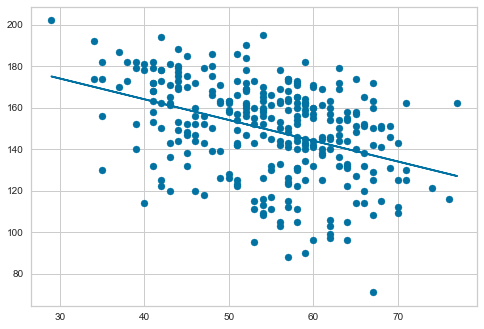

In [18]:
def linear_regression(x):
    return slope * x + intercept

linreg_model = list(map(linear_regression, x))

plt.scatter(x, y)
plt.plot(x, linreg_model)
plt.show()

In [19]:
print("Intercept:", intercept)
print("Коэффициент корреляции Пирсона равен:", r)
print("Коэффициент p-value равен:", p)

Intercept: 204.01599030122034
Коэффициент корреляции Пирсона равен: -0.39523518755348014
Коэффициент p-value равен: 9.85830359409439e-13


Т.к. коэффициент p-value < 0,05, мы отлконяем нулевую гипотезу в пользу альтернативной: действительно, между переменными age и thalach существует зависимость. Коэффициент корреляции Пирсона составляет -0,39, что говорит об умеренной негативной связи между переменными. Так, при повышении возраста у пациента снижается показатель thalach 

Предсказания на основе модели:

In [20]:
print("В 18 лет показатель thalach будет равен:", linear_regression(18))
print("В 80 лет показатель thalach будет равен:", linear_regression(80))

В 18 лет показатель thalach будет равен: 186.00741571786568
В 80 лет показатель thalach будет равен: 123.97788104186634


На предсказаниях видно, что повышение возраста пациента отрицательно связано с показателем thalach

####  Логистическая регрессия

Реализуем логистическую регрессию и посмотрим, какие переменные вносят наибольший статистически значимый вклад в предсказание наличия заболевания у пациента. 

In [21]:
import statsmodels.api as sm

In [22]:
X = df_clear.drop(labels='target', axis=1)
y = df_clear['target']
X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.348265
         Iterations 7


In [23]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  302
Model:                          Logit   Df Residuals:                      288
Method:                           MLE   Df Model:                           13
Date:                Wed, 25 Oct 2023   Pseudo R-squ.:                  0.4949
Time:                        07:41:47   Log-Likelihood:                -105.18
converged:                       True   LL-Null:                       -208.21
Covariance Type:            nonrobust   LLR p-value:                 7.740e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3042      2.578      1.282      0.200      -1.748       8.357
age           -0.0015      0.023     -0.063      0.950      -0.047       0.045
sex           -1.7509      0.468     -3.740      0.0

**const** - intercept = 3.3042. Коэффициент равен логарифму отношения шансов для целевого класса (класс 1) в сравнении с базовым классом (класс 0) при всех независимых переменных равных нулю.

**Статистически значимыми факторами являются:**

**sex:** коэффициент -1.7509, p-value < 0.001, значит, коэффициент статистически значим и отрицателен. Это говорит о том, что означает, что мужчины (если переменная sex = 1) имеют более низкую вероятность заболевания (т.е. принадлежности к классу 1) по сравнению с женщинами (если sex = 0).

**cp** (боли в груди): коэффициент 0.8473, p-value < 0.001. Коэффициент статистически значим и положителен, что указывает на положительную связь между интенсивностью болей в груди и вероятностью наличия сердечных заболеваний.

**trestbps**: коэффициент -0.0202, при этом p-value 0.052, что близко к статистическому уровню значимости 0,05. При этом сам коэффициент близок к нулю, поэтому, даже если влияние стат. значимо, оно незначительно. 

**thalach** (максимальная достигнутая частота сердечных сокращений): коэффициент 0.0231, p-value 0.027. Увеличение показателя thalach положительно влияет на вероятность наличия сердечного заболевания (чем выше максимальная достигнутая частота сердечных сокращений, тем больше вероятность принадлежности к классу 1).

**exang** (стенокардия, вызванная физической нагрузкой): коэффициент -0.9810, p-value 0.017. Значит, наличие стенокардии, вызванной физической нагрузкой (если exang = 1), отрицательно влияет на вероятность наличия заболевания. То есть, при наличии этого симптома, вероятность заболевания снижается.

**oldpeak** (депрессия ST-сегмента после физической нагрузки): коэффициент -0.5236, p-value 0.015. Это говорит о том, что увеличение значения депрессии ST-сегмента после физической нагрузки также отрицательно влияет на вероятность наличия заболевания у пациента. Большее значение oldpeak связано с меньшей вероятностью заболевания.

**ca** (количество крупных сосудов (0-3), окрашенных средой X-ray): коэффициент -0.8260, p-value < 0.001. Это означает, что увеличение количества крупных сосудов, окрашенных средой X-ray, уменьшает вероятность принадлежности к классу 1, т.е. наличия заболевания. 

**thal** (тип талассемии): коэффициент -0.8872, p-value 0.002. Значит, тип талассемии (если thal = 1) отрицательно влияет на вероятность наличия заболевания у пациента.


Псевдо **R-квадрат равен 0.4949**, что говорит о том, что модель объясняет примерно 49.49% изменчивости в данных.

Для решения задачи классификации сначала воспользуемся логистической регрессией как базовым инструментом. 
По имеющимся параметрам попробуем определить, есть ли у пациента заболевание

In [24]:
X = df_clear.drop(labels='target', axis=1).values
y = df_clear['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
logreg = LogisticRegression()
scaler = StandardScaler()

In [26]:
pipeline = make_pipeline(scaler, logreg)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

testing_accuracy = pipeline.score(X_test, y_test)
training_accuracy = pipeline.score(X_train, y_train)

print(classification_report(y_test, y_pred))
print('')
print(f'Training accuracy: {training_accuracy}')
print(f'Testing accuracy: {testing_accuracy}')

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        25
           1       0.86      0.86      0.86        36

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61


Training accuracy: 0.8506224066390041
Testing accuracy: 0.8360655737704918


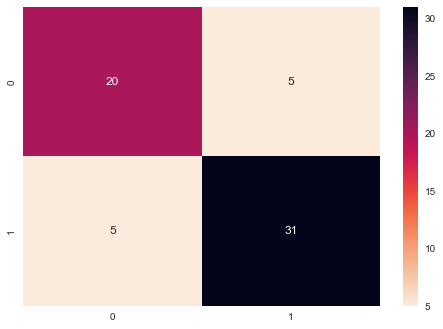

In [27]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='rocket_r')
plt.show()

Модель с точностью 0.85 определяет наличие у пациента заболевания

**Вывод**

Таким образом, мы определили переменные, которые имеют статистически значимую связь с наличием/отсутствием сердечного заболевания: sex, cp, trestbps, thalach, exang, oldpeak, ca, thal. 
Далее, мы построили модель логистической регрессии, которая с точностью 0.85 определяет, болен ли пациент. 

## Классификация

На основе имеющихся признаков сделаем классификатор, который будет определять, есть ли у пациента заболевание. Для этого попробуем применить два метода - Decision Tree и Random Forest

#### Decision tree

In [28]:
y = df_clear['target']
X = df_clear.drop('target',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, Y_pred)

print(classification_report(y_test,Y_pred))
print("Decision Tree Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.77      0.80      0.78        25
           1       0.86      0.83      0.85        36

    accuracy                           0.82        61
   macro avg       0.81      0.82      0.81        61
weighted avg       0.82      0.82      0.82        61

Decision Tree Accuracy: 0.819672131147541


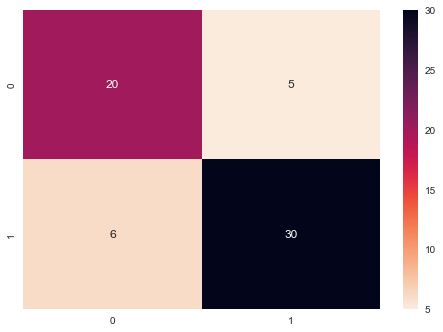

In [30]:
cm = confusion_matrix(y_test, Y_pred)

sns.heatmap(cm, annot=True, cmap='rocket_r')
plt.show()

Мы видим, что алгоритм Decision Tree справляется с задачей даже чуть хуже, чем модель логистической регрессии, accuracy составляет лишь 0,82. Это может быть связно с тем, что алгоритм склонен к переобучению, может быть чувствительным к небольшим изменениям в данных. Поэтому попробуем для улучшения результата применить Random Forest - ансамбльный метод, в котором используется множество деревьев.

#### Random Forest

In [31]:
random_forest = RandomForestClassifier(n_estimators=10, random_state=0, max_depth=5)

random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, Y_pred)

print(classification_report(y_test,Y_pred))
print("Random Forest Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.86      0.89      0.88        36

    accuracy                           0.85        61
   macro avg       0.85      0.84      0.85        61
weighted avg       0.85      0.85      0.85        61

Random Forest Accuracy: 0.8524590163934426


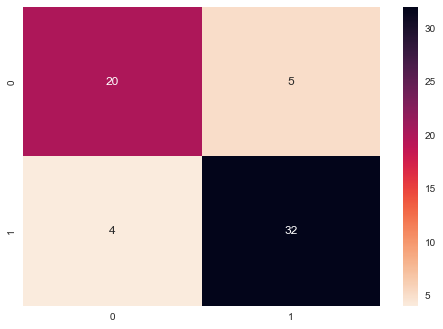

In [32]:
cm = confusion_matrix(y_test, Y_pred)

sns.heatmap(cm, annot=True, cmap='rocket_r')
plt.show()

Как видно из анализа, Random Forest более точно по сравнению с Decision Tree относит пациентов к одному из классов, accuracy составляет 0,85. При этом он работает на одном уровне с логистической регрессией.

**Вывод**

Таким образом, всего мы построили три классификатора: модель логистической регрессии, Decision Tree и Random Forest. Мы увидели, что логистическая регрессия и Random Forest справляются с задачей примерно одинаково с accuracy ±0,85. Чуть хуже показал себя алгоритм Decision Tree, accuracy которого составила 0,82. 

## Кластеризация

Объединим пациентов в кластеры и посмотрим, какие общие паттерны есть у людей с заболеванием и без.
Применим Elbow method для определения оптимального числа кластеров для нашей выборки.

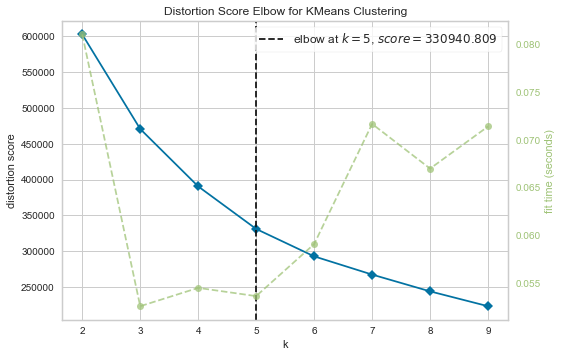

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(df_clear)
visualizer.show() 

Из графика видно, что оптимальное число кластеров для нашей выборки - 5.

In [34]:
sc = StandardScaler()
x_sc = sc.fit_transform(df_clear)

km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(x_sc)

In [35]:
df_clear_clust = df_clear.copy()

In [36]:
df_clear_clust['cluster_km'] = labels
df_clear_clust['cluster_km'].value_counts()

1    79
0    70
2    64
3    53
4    36
Name: cluster_km, dtype: int64

In [37]:
cluster_mean = df_clear_clust.groupby('cluster_km').mean().reset_index()
cluster_mean

,cluster_km,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,56.642857,0.857143,0.100000,131.071429,247.328571,0.014286,0.571429,126.471429,0.857143,1.868571,1.028571,0.871429,2.628571,0.057143
1,1,46.645570,0.860759,1.000000,123.759494,227.455696,0.050633,0.746835,166.594937,0.101266,0.279747,1.860759,0.303797,2.227848,0.835443
2,2,57.640625,0.046875,1.218750,131.265625,270.125000,0.093750,0.484375,151.640625,0.109375,0.535937,1.625000,0.343750,1.984375,0.968750
3,3,55.396226,0.962264,2.226415,136.622642,231.924528,0.283019,0.396226,156.905660,0.113208,1.307547,1.132075,0.603774,2.377358,0.584906
4,4,60.000000,0.666667,0.250000,143.055556,266.138889,0.527778,0.222222,142.638889,0.500000,1.625000,1.083333,2.166667,2.388889,0.027778


Разделили выборку на 5 кластеров:

**Кластер 1 - не имеют заболевания:**
- средний возраст - 56 лет
- 85% пациентов - мужчины
- боль в груди практически отсутствует (средний показатель равен 0,1)
- среднее давление в состоянии покоя - 131
- холестерол в среднем равен 247
- fasting blood sugar в среднем менее 120 mg/dl
- среднее значение по показателю thalach - 126
- средний показатель exercise induced angina - 85,7%
- средний показатель oldpeak - 1,86
- slope равен 1
- ca - 0,87
- thal - в среднем 2,62
- target равен 0,05 - большинство пациентов в кластере не имеют заболевания

**Кластер 2 - 83% заболеваний:**
- средний возраст - 46 лет
- 86% пациентов - мужчины
- боль в груди присутствует у всех пациентов (средний показатель равен 1)
- среднее давление в состоянии покоя - 123
- холестерол в среднем равен 227
- fasting blood sugar в среднем менее 120 mg/dl
- среднее значение по показателю thalach - 166
- средний показатель exercise induced angina - 10%
- средний показатель oldpeak - 0,27
- slope равен 1,8
- ca - 0,3
- thal - в среднем 2,22
- target равен 0,83 - большинство пациентов в кластере имеют заболевание

**Кластер 3 - 96,8% заболеваний:**
- средний возраст - 57 лет
- ок. 95% пациентов - женщины
- боль в груди присутствует у всех пациентов (средний показатель равен 1,2)
- среднее давление в состоянии покоя - 131
- холестерол в среднем равен 270
- fasting blood sugar в среднем менее 120 mg/dl
- среднее значение по показателю thalach - 151
- средний показатель exercise induced angina - 10%
- средний показатель oldpeak - 0,53
- slope равен 1,6
- ca - 0,34
- thal - в среднем 1,98
- target равен 0,968 - большинство пациентов в кластере имеют заболевание

**Кластер 4 - 58% имеют заболевания:**
- средний возраст - 55 лет
- 96% пациентов - мужчины
- наиболее высокая среди всех классов боль в груди (средний показатель равен 2,22)
- среднее давление в состоянии покоя - 136
- холестерол в среднем равен 231
- fasting blood sugar в среднем менее 120 mg/dl
- среднее значение по показателю thalach - 157
- средний показатель exercise induced angina - 11%
- средний показатель oldpeak - 1,3
- slope равен 1,13
- ca - 0,6
- thal - в среднем 2,37
- target равен 0,58 - чуть больше половины пациентов в кластере имеют заболевание

**Кластер 5 - не имеют заболевания:**
- средний возраст - 60 лет
- 66% пациентов - мужчины, 34% - женщины
- в среднем боль в груди практически отсутствует (средний показатель равен 0,25)
- среднее давление в состоянии покоя - 143
- холестерол в среднем равен 266
- fasting blood sugar в среднем менее 120 mg/dl
- среднее значение по показателю thalach - 142
- средний показатель exercise induced angina - 50%
- средний показатель oldpeak - 1,62
- slope равен 1
- ca - 2,16
- thal - в среднем 2,38
- target равен 0,027 - практически все пациенты в кластере не имеют заболевания

**Общий вывод**

Таким образом, в ходе анализа мы выявили переменные, имеющие статистически значимую связь с наличием или отсутствием заболевания у пациентов и вносящие наибольший вклад в предсказание наличия заболевания. Среди таких переменных: sex, cp, trestbps, thalach, exang, oldpeak, ca, thal. Мы увидели, что женщины чаще страдают от сердечных заболеваний, чем мужчины. Как правило, у людей, имеющих заболевание, сильнее выражены боли в груди (однако здесь сложно судить, что является причиной, а что следствием). Кроме того, увеличение показателя thalach также связано с наличием заболевания. Помимо этого, часть переменных, напротив, понижают вероятность заболевания, это - exang, oldpeak, ca и thal. 

Затем мы построили три модели для бинарной классификации (логистическая регрессия, Random Forest, Decision Tree), чтобы иметь возможность по заданным признакам предсказать наличие у пациента сердечного заболевания. Лучше всего себя показали логистическая регрессия и Random Forest.

Наконец, мы провели кластерный анализ и разделили имеющуюся выборку на 5 кластеров. Из них в 2 кластера выделены пациенты, не имеющие заболевания, еще в 2 - пациенты с сердечными заболеваниями, в одном из кластеров больных и здоровых пациентов оказалось примерно поровну. 

При этом при первичной обработке данных мы удалили из датасета более 700 дублирующихся значений, в результате чего в датасете осталось всего 302 наблюдения. Возможно, на более крупном датасете мы смогли бы получить более точные результаты.